# King County Housing Regression Project

## Table Of Contents
<font size=3rem>
    
0 -**[ INTRO](#INTRODUCTION)<br>**
1 -**[ OBTAIN](#OBTAIN)**<br>
2 -**[ SCRUB](#SCRUB)**<br>
3 -**[ EXPLORE](#EXPLORE)**<br>
4 -**[ MODEL](#MODEL)**<br>
5 -**[ INTERPRET](#INTERPRET)**<br>
6 -**[ CONCLUSIONS & RECCOMENDATIONS](#Conclusions-&-Recommendations)<br>**
</font>
___

# INTRODUCTION

* Students: Cody Freese/Fennec Nightingale/Thomas Cornett
* Pace: Part time
* Instructor: Amber Yandow
* Blog post URL:

<p> In this notebook we're going to be using the OSEMN model to do OLS regression on housing data from King County in 2015. Here we'll be looking to answer questions like:</p><p> What factors impact the price of a home?</p>
<p> What factors impact the price of a home for different income levels?</p>
<p> If you're looking to move to king county, where is the best bang for your buck?</p>

## Import Tools

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import mlxtend

In [2]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

In [3]:
from math import sin, cos, sqrt, atan2, radians
from sklearn import svm
from scipy.stats import zscore
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Editing Our Settings 
We have too many columns to view normally, and it's difficult to get a good grasp of our data with how much is normally cut off. 


In [4]:
%matplotlib inline
plt.style.use('dark_background')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = '#FBE122'
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Define functions 

In [5]:
def getClosest(home_lat: float, home_lon: float, dest_lat_series: 'series', dest_lon_series: 'series'):
    """Pass 1 set of coordinates and one latitude or longitude column you would like to compare it's distance to"""
    #radius of the earth in miles 
    r = 3963
    #setting variables to use to iterate through  
    closest = 100
    within_mile = 0
    i = 0
    #using a while loop to iterate over our data and calculate the distance between each datapoint and our homes 
    while i < dest_lat_series.size:
        lat_dist = radians(home_lat) - (dest_lat := radians(dest_lat_series.iloc[i]))
        lon_dist = radians(home_lon) - (radians(dest_lon_series.iloc[i]))
        a = sin(lat_dist / 2)**2 + cos(radians(home_lat)) * cos(radians(dest_lat)) * sin(lon_dist / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        c = r * c 
        #find the closest data to our homes by keeping our smallest (closest) value
        if (c < closest):
            closest = c
        #find all of the points that fall within one mile and count them 
        if (c <= 1.0):
            within_mile += 1
        i += 1
    return [closest, within_mile]

In [6]:
def plotcoef(model):
    """Takes in OLS results and returns a plot of the coefficients"""
    #make dataframe from summary of results 
    coef_df = pd.DataFrame(model.summary().tables[1].data)
    #rename your columns
    coef_df.columns = coef_df.iloc[0]
    #drop header row 
    coef_df = coef_df.drop(0)
    #set index to variables
    coef_df = coef_df.set_index(coef_df.columns[0])
    #change dtype from obj to float
    coef_df = coef_df.astype(float)
    #get errors
    err = coef_df['coef'] - coef_df['[0.025']
    #append err to end of dataframe 
    coef_df['errors'] = err
    #sort values for plotting 
    coef_df = coef_df.sort_values(by=['coef'])
    ## plotting time ##
    var = list(coef_df.index.values)
    #add variables column to dataframe 
    coef_df['var'] = var
    # define fig 
    fig, ax = plt.subplots(figsize=(8,5))
    #error bars for 95% confidence interval
    coef_df.plot(x='var', y='coef', kind='bar',
                ax=ax, fontsize=15, yerr='errors', color='#FBE122', ecolor = '#FBE122')
    #set title and label 
    plt.title('Coefficients of Features With 95% Confidence Interval', fontsize=20)
    ax.set_ylabel('Coefficients', fontsize=15)
    ax.set_xlabel(' ')
    #coefficients 
    ax.scatter(x= np.arange(coef_df.shape[0]),
              marker='+', s=50, 
              y=coef_df['coef'], color='#FBE122')
    plt.legend(fontsize= 15,frameon=True, fancybox=True, facecolor='black')
    return plt.show()

In [7]:
def make_ols(df, x_columns,target='price'):
    """Pass in a DataFrame & your predictive columns to return an OLS regression model """
    #set your x and y variables
    X = df[x_columns]
    y = df[target]
    # pass them into stats models OLS package
    ols = sm.OLS(y, X)
    #fit your model
    model = ols.fit()
    #display the model summarry
    display(model.summary())
    #plot the residuals 
    fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='r', alpha=.65, fit=True, markerfacecolor="#FBE122")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    #return model for later use 
    return model

In [8]:
def get_percentile(data_n_col):
    """Print out all of your percentiles for a given column in a dataframe
       Example: data['price'] """
    for i in range(1,100):
        q = i / 100
        print('{} percentile: {}'.format(q, data_n_col.quantile(q=q)))

# OBTAIN DATA
Here we'll be working with the King County housing data provided to us by FlatIron and data about schools in King County gathered by ArcGis. We'll be importing them via the Pandas library. 

In [9]:
#wrote up our data types to save on computer space and stop some of them from being inccorectly read as objs
kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 
             'floors': float, 'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 
             'yr_built': int, 'yr_renovated': float, 'zipcode': float, 'lat': float, 'long': float}

In [10]:
# Data provided from Flatiron 
kc_data = pd.read_csv(r'~\Documents\Flatiron\data\data\kc_house_data.csv', parse_dates = ['date'], dtype=kc_dtypes)
# Data gathered from ArcGis
schools = pd.read_csv(r'~\Documents\Flatiron\data\data\Schools.csv')
foods = pd.read_csv(r'~\Documents\Flatiron\pro2\foods.csv')

In [11]:
#i've already calculated all of the distances and added them to a dataframe, if you want to skip that
#import this and skip straight to kc_data.rename and run everything as normal 
kc_data = pd.read_csv(r'~\Documents\Flatiron\pro2\kc_data.csv')

In [ ]:
# Removing latitudes and longitudes that couldn't be found from adresses in ArcGis data 
foods = foods.loc[foods['lat'] != '[0.0]'].copy()
foods = foods.loc[foods['long'] != '[0.0]'].copy()
# Convert latitude and longitude into floats so we can use them to calculate distance 
foods['lat'] = foods['lat'].astype(dtype=float)
foods['long'] = foods['long'].astype(dtype=float)

In [ ]:
# Seperate grocery stores from restaurants
rest = foods.loc[foods['SEAT_CAP'] != 'Grocery']
groc = foods.loc[foods['SEAT_CAP'] == 'Grocery']

In [ ]:
# we can't append these directly into a DataFrame very easily, so we're going to start an empty dictionary 
# that's going to store all of our values and be converted into a dataframe later on 
kc_dict = {}

In [ ]:
i = 0
# here we're going to iterate over the latitude and longitude of each house, and calculate the 
# distance between our housing and our other dataframes 
while i < kc_data['lat'].size:
    school = getClosest(kc_data['lat'].iloc[i], kc_data['long'].iloc[i], schools['LAT_CEN'], schools['LONG_CEN'])
    restaurant = getClosest(kc_data['lat'].iloc[i], kc_data['long'].iloc[i], rest['lat'], rest['long'])
    grocery = getClosest(kc_data['lat'].iloc[i], kc_data['long'].iloc[i], groc['lat'], groc['long'])
    kc_dict[i] = {
        "closest school": school[0],
        "schools within mile": school[1],
        "closest restaurant": restaurant[0],
        "restaurants within mile": restaurant[1],
        "closest grocery": grocery[0],
        "groceries within mile": grocery[1]}
    i += 1 

That's all of the data we need to start. Now we'll be adding the last of our data, merging in the distance between the schools and our homes. 

In [ ]:
# let's turn our dictionary into a dataframe we can work with 
kc = pd.DataFrame.from_dict(kc_dict, orient='index')
# it will be the same length as our dataframe and in the same order, so we're going to merge it on index
kc_data = kc_data.merge(kc, left_index=True, right_index=True)

In [12]:
# though nice in dictionary form, we shouldnt have spaces in our names for our dataframes so we'll
# be renaming them here, but keeping the dictionary in case anyone needs to reference what each name means 
kc_data = kc_data.rename(columns ={'closest school': 'mi_2_scl', 'schools within mile': 'scls_in_mi', 'closest restaurant':'mi_2_rest', 
                          'restaurants within mile':'rest_in_mi','closest grocery': 'mi_2_groc', 'groceries within mile': 'groc_in_mi'})

Now let's take a look at our data to see what we are working with and what we might need to fix 

In [13]:
kc_data.isnull().sum()

Unnamed: 0          0
id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
mi_2_scl            0
scls_in_mi          0
mi_2_rest           0
rest_in_mi          0
mi_2_groc           0
groc_in_mi          0
dtype: int64

# SCRUB
Cleaning up our data, filling NaN values, dropping unnecessary columns 

In [14]:
kc_data = kc_data.drop(['id', 'date'], 1)

In [15]:
#to use sqft basment later on we need to convert it to a float 
kc_data['sqft_basement'] = kc_data['sqft_basement'].replace({'?': 0})
kc_data['sqft_basement'] = kc_data['sqft_basement'].astype(dtype=float)

As we can see we have 3 columns with null values, after exploring them, it makes the most sense to fill the null values with zeros, which is what they had been using to indicate a column without anything anyways. 

In [16]:
kc_data = kc_data.fillna(0)

In [17]:
#Convert to integer for whole number year, not sure why it'll let us reassign it here but raise errors in dtypes
kc_data['yr_renovated'] = kc_data['yr_renovated'].astype('int')

### Add Dummy Variables<p>
Catagorical columns needs to be transformed so we can use them in our model.</p>
<p>
thankfully, the Pandas library has got us covered with pd.get_dummies()</p>

In [18]:
# fixing condition to be a good or bad, hoping that'll help get rid of the multicolinearity 
kc_data['condition'] = kc_data.condition.replace(to_replace = [1.0, 2.0, 3.0, 4.0, 5.0],  value= ['bad', 'bad', 'good', 'good', 'good'])

In [19]:
#we have 70 zipcodes and 120 years, it would add too much complexity to our data to increase it by 190 columns
# so instead, we're going to go through and bin them! 
zips = []
years = []


for zipcode in kc_data.zipcode:
    zips.append(zipcode)
for year in kc_data.yr_built:
    years.append(year)
    
zips = list(set(zips))
years = list(set(years))

zips.sort()
years.sort()

In [20]:
#will have to find a way to write this into a loop at some point, but, I can't figure out how to get .replace()
#to adequatley read lists of lists while also giving them unique names, so for now this works 
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[0:5],  value= 'zip001t005')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[5:10], value= 'zip006t011')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[10:15], value= 'zip014t024')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[15:20], value= 'zip027t031')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[20:25], value= 'zip032t039')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[25:30], value= 'zip040t053')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[30:35], value= 'zip055t065')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[35:40], value= 'zip070t077')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[40:45], value= 'zip092t106')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[45:50], value= 'zip107t115')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[50:55], value= 'zip116t122')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[55:60], value= 'zip125t144')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[60:65], value= 'zip146t168')
kc_data['zipcode'] = kc_data.zipcode.replace(to_replace = zips[65:70], value= 'zip177t199')

In [21]:
#gonna do the same for year built by 20 years, will give us 6 new columns, may be illuminating 
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[0:20], value= 'thru20')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[20:40], value= 'thru40')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[40:60], value= 'thru60')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[60:80], value= 'thru80')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[80:100], value= 'thru2000')
kc_data['yr_built'] = kc_data.yr_built.replace(to_replace = years[100:120], value= 'thru2020')

In [22]:
# get dummies of our new variables 
dummys = ['zipcode', 'yr_built', 'condition', ]

for dummy in dummys:
    dumm = pd.get_dummies(kc_data[dummy], drop_first=True)
    kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

#we're doing something unique to these variables so it wouldn't save us any time to put them into a loop
dumm = pd.get_dummies(kc_data['view'], prefix='view', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)
dumm = pd.get_dummies(kc_data['grade'], prefix='gra', drop_first=True, dtype=int)
kc_data = kc_data.merge(dumm, left_index=True, right_index=True)

In [23]:
#break up variables into diverse ranges & renaming our dummies so that they'r easier to interpret 
kc_data = kc_data.rename({'view_1.0': 'view1', 'view_2.0': 'view2', 'view_3.0': 'view3', 'view_4.0':'view4'},axis=1)
kc_data = kc_data.rename({'gra_4': 'D', 'gra_5':'Cmin', 'gra_6':'C','gra_7':'Cpl', 'gra_8':'Bmin', 'gra_9':'B',
                          'gra_10':'Bpl', 'gra_11':'Amin', 'gra_12':'A', 'gra_13':'Apl'},axis=1)

# EXPLORE

Now that we have all of the data we'll need ready to go we can really start digging in and checking it out! 

## Histogram

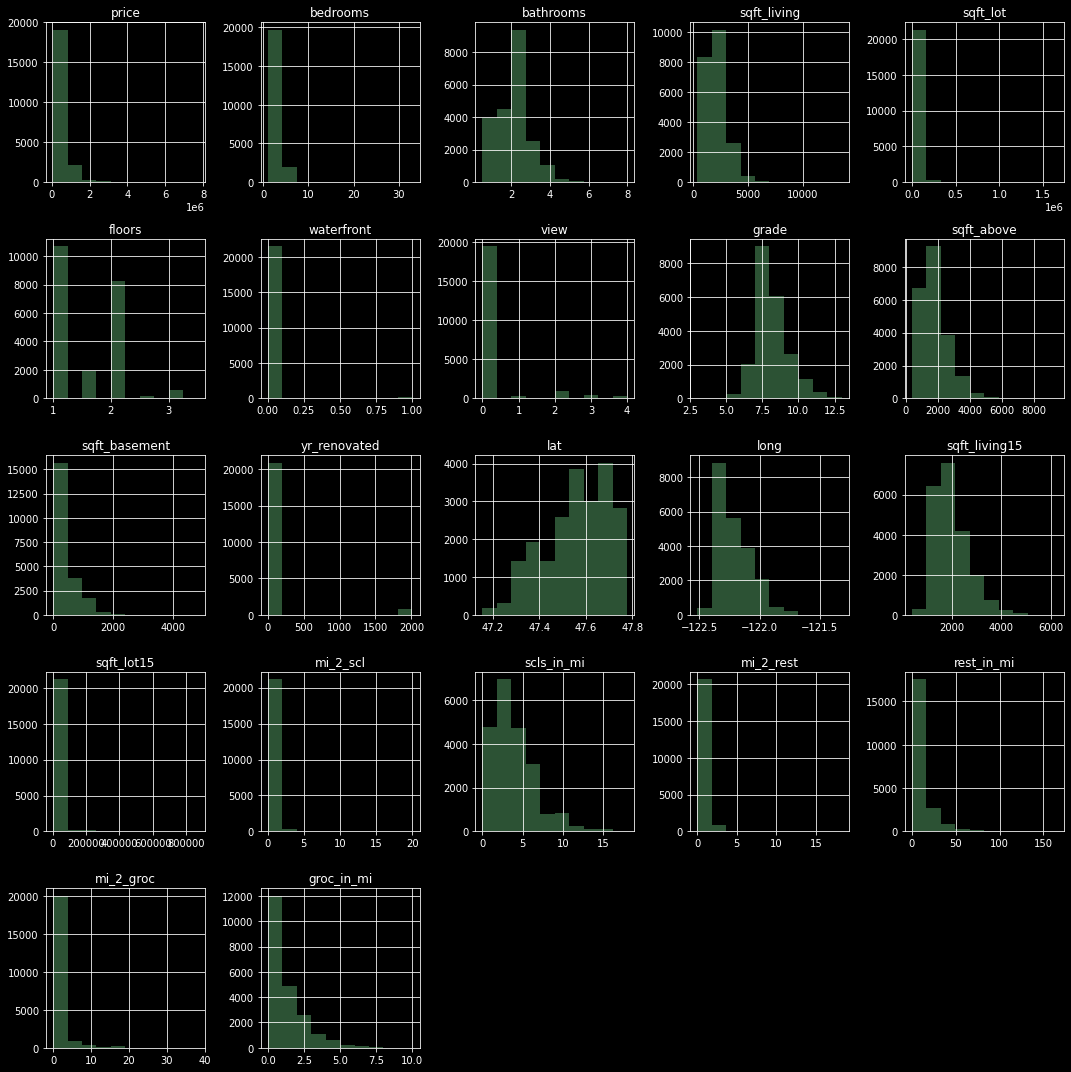

In [24]:
# looking at a histogram of value counts for al of our data can give us a sense of how it's 
#distributed and what columns we might have issues with 
hist = kc_data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
                'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 
                'lat', 'long', 'sqft_living15', 'sqft_lot15', 'mi_2_scl', 'scls_in_mi', 'mi_2_rest',
                'rest_in_mi', 'mi_2_groc', 'groc_in_mi']]
hist.hist(figsize=(15,15), color='#2C5234')
plt.tight_layout()

## Scatter Matrix

In [25]:
# a scatter matrix will compare all of our columns against eachother, it's very large and takes a while 
# with so much data, but can be really informative 
# fig = pd.plotting.scatter_matrix(kc_data,figsize=(16,16));

## Heatmap

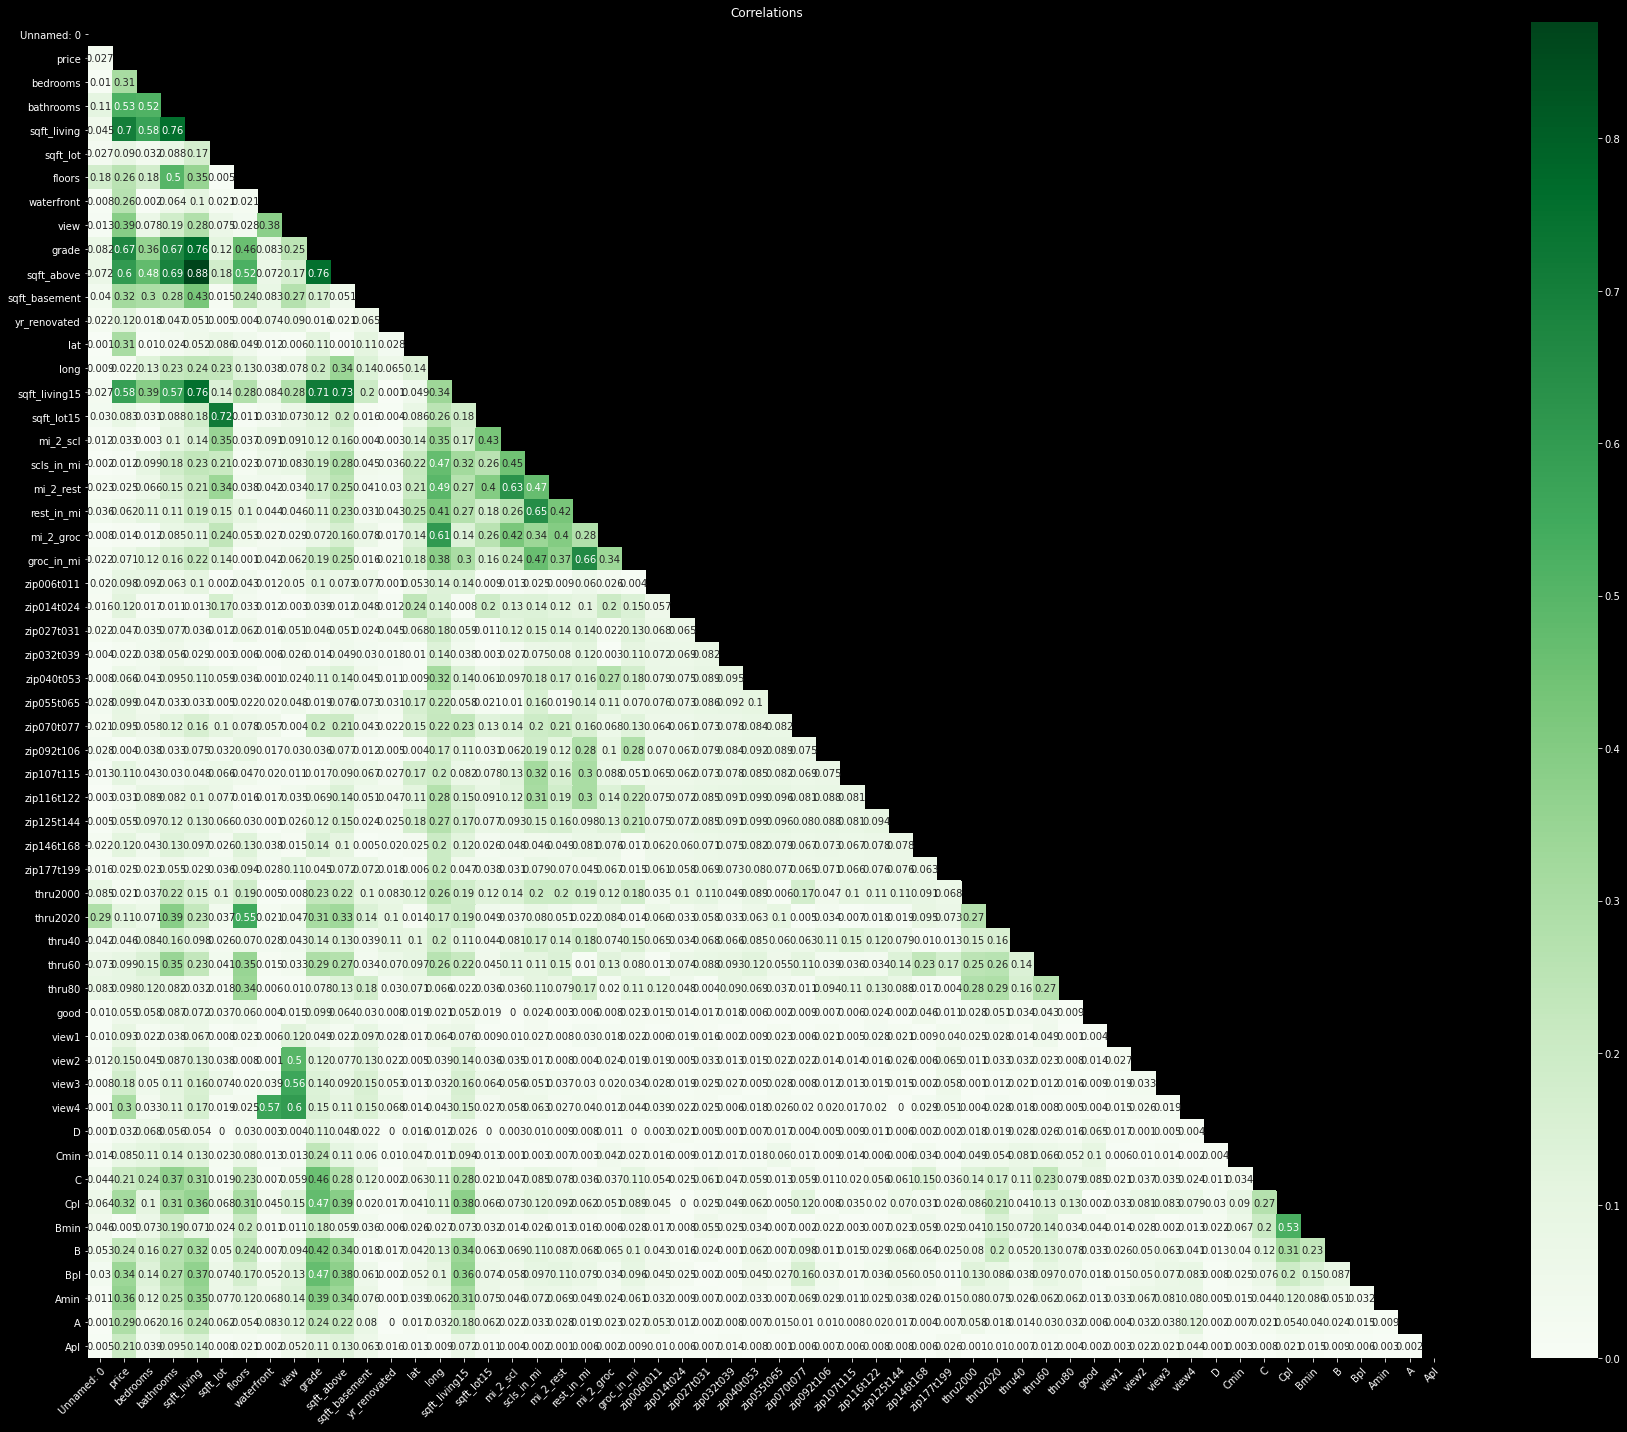

In [26]:
#a heatmap will help visualize the multicolinearity in our data and help us to see if anything stands out l
fig, ax = plt.subplots(figsize=(25,20))
corr = kc_data.corr().abs().round(3)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, annot=True, mask=mask, cmap='Greens', ax=ax)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')
fig.tight_layout()

We can see some colinearity between our features, it's best to either remove or transform them if we want to use them in our model

If we were to multiply by basement to try and get rid of the correlation, we'd be multiplying by a bunch of zeros and it wouldn't adequetly represent our data. By adding one to every 'sqft_basement' that is equal to zero, when we multiply if there are no basement values we still keep our 'sqft_above' values. 

In [27]:
kc_data['sqft_basement'] = kc_data['sqft_basement'].map(lambda x :  1 if x == 0 else x )

In [28]:
#getting rid of multicolinearity in sqftage 
kc_data['sqft_total'] = kc_data['sqft_living']*kc_data['sqft_lot']
kc_data['sqft_neighb'] = kc_data['sqft_living15']*kc_data['sqft_lot15']
kc_data['sqft_habitable'] = kc_data['sqft_above']*kc_data['sqft_basement']

In [29]:
#print columns we will be using going forward 
#make a copy of the dataframe holding only columns we'll be including
kc_data.columns
all_data = kc_data.copy()
kc_data = kc_data[['price', 'bedrooms', 'bathrooms', 'floors','waterfront', 
                   'yr_renovated', 'lat', 'long', 
                   'sqft_total', 'sqft_neighb', 'sqft_habitable', 
                   'good', 'view1', 'view2', 'view3', 'view4', 
                   'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin', 
                   'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
                   'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
                   'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
                   'zip177t199', 
                   'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
                   'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi']].copy()

# MODEL

## Initial Models on Price

In [30]:
#seperating our data into different income brackets, as a 100,000 house is unlikely to be helpful
#in predicting the price of a 1,000,000 house 
hightier = kc_data[kc_data.price >800000]
midtier = kc_data[(kc_data.price > 300001) & (kc_data.price<=800000) ]
lowtier = kc_data[kc_data.price <=300000]

In [31]:
#as we go through we will notice that some features apply to different income brackets, 
#so seperating them out helps us choose the features that best apply to each of them 

highincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
          'yr_renovated', 'lat', 'long', 
          'sqft_total', 'sqft_neighb', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4', 
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin',  
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
          'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi']

mediumincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
          'yr_renovated', 'lat', 'long', 
          'sqft_total', 'sqft_neighb', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4', 
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin',  
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
          'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi']

lowincome = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 
          'yr_renovated', 'lat', 'long', 
          'sqft_total', 'sqft_neighb', 'sqft_habitable', 
          'good', 'view1', 'view2', 'view3', 'view4', 
          'D', 'Cmin', 'C', 'Cpl', 'Bmin', 'B', 'Bpl', 'Amin',  
          'zip006t011', 'zip014t024', 'zip027t031', 'zip032t039', 
          'zip040t053', 'zip055t065', 'zip070t077', 'zip092t106', 
          'zip107t115', 'zip116t122', 'zip125t144', 'zip146t168', 
          'zip177t199', 
          'thru2000', 'thru2020', 'thru40', 'thru60', 'thru80',
          'mi_2_scl', 'scls_in_mi', 'mi_2_rest', 'rest_in_mi', 'mi_2_groc', 'groc_in_mi']

In [32]:
#putting all of our price brackets together to go into our model 
price_tiers = [('high', hightier, highincome),
               ('mid', midtier, mediumincome),
               ('low', lowtier, lowincome)]

LOW


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.978
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              4506.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        18:15:09   Log-Likelihood:                         -54335.
No. Observations:                4561   AIC:                                  1.088e+05
Df Residuals:                    4516   BIC:                                  1.091e+05
Df Model:                          45                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        5000.6701    850.440      5.880      0.000    3333.391    6667.949
bathrooms       1.901e+04   1456.422     13.050      0.000    1.62e+04    2.19e+04
floors          1950.4887   1881.319      1.037      0.300   -1737.817    5638.794
waterfront      4.215e+04   3.17e+04      1.328      0.184   -2.01e+04    1.04e+05
yr_renovated       1.2960      1.946      0.666      0.506      -2.520       5.112
lat             8.423e+04   6232.485     13.514      0.000     7.2e+04    9.64e+04
long            3.099e+04   2421.649     12.796      0.000    2.62e+04    3.57e+04
sqft_total      8.017e-05   2.26e-05      3.541      0.000    3.58e-05       0.000
sqft_neighb     1.295e-05   2.27e-05      0.571      0.568   -3.15e-05    5.74e-05
sqft_habitable     0.0115      0.002      6.185      0.000       0.008       0.015
good            3.505e+04   3628.665      9.658      0.000    2.79e+04    4.22e+04
view1            3.14e+04   1.02e+04      3.081      0.002    1.14e+04    5.14e+04
view2            2.01e+04   5098.013      3.942      0.000    1.01e+04    3.01e+04
view3           2.249e+04   1.05e+04      2.135      0.033    1836.976    4.31e+04
view4           4.303e+04   3.02e+04      1.426      0.154   -1.61e+04    1.02e+05
D               -1.11e+05   3.73e+04     -2.977      0.003   -1.84e+05   -3.79e+04
Cmin           -9.278e+04   3.66e+04     -2.538      0.011   -1.64e+05   -2.11e+04
C              -6.974e+04   3.65e+04     -1.911      0.056   -1.41e+05    1789.018
Cpl            -5.358e+04   3.65e+04     -1.467      0.142   -1.25e+05     1.8e+04
Bmin           -4.142e+04   3.66e+04     -1.133      0.257   -1.13e+05    3.03e+04
B              -4.631e+04   3.75e+04     -1.236      0.217    -1.2e+05    2.72e+04
Bpl            -2.647e-11   6.99e-11     -0.379      0.705   -1.64e-10    1.11e-10
Amin           -5.322e-10   2.85e-10     -1.866      0.062   -1.09e-09    2.71e-11
zip006t011      7472.1142   5544.517      1.348      0.178   -3397.852    1.83e+04
zip014t024      5290.4672   2295.729      2.304      0.021     789.715    9791.219
zip027t031      5386.5259   2618.441      2.057      0.040     253.101    1.05e+04
zip032t039      2924.2244   2730.256      1.071      0.284   -2428.414    8276.863
zip040t053      2501.3695   2684.268      0.932      0.351   -2761.109    7763.848
zip055t065      1.181e+04   2571.133      4.595      0.000    6772.819    1.69e+04
zip070t077      3.774e+04   7918.899      4.766      0.000    2.22e+04    5.33e+04
zip092t106      9040.6905   2638.404      3.427      0.001    3868.128    1.42e+04
zip107t115      6163.5910   4821.326      1.278      0.201   -3288.567    1.56e+04
zip116t122      1.251e+04   3709.824      3.372      0.001    5237.536    1.98e

MID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              8615.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        18:15:10   Log-Likelihood:                     -1.8142e+05
No. Observations:               14093   AIC:                                  3.629e+05
Df Residuals:                   14046   BIC:                                  3.633e+05
Df Model:                          47                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms        1.063e+04   1051.014     10.110      0.000    8565.381    1.27e+04
bathrooms       3.454e+04   1909.079     18.093      0.000    3.08e+04    3.83e+04
floors          3434.5050   2270.008      1.513      0.130   -1015.013    7884.023
waterfront      8.803e+04   1.94e+04      4.528      0.000    4.99e+04    1.26e+05
yr_renovated       1.7188      2.497      0.688      0.491      -3.176       6.614
lat             3.481e+05   7423.274     46.893      0.000    3.34e+05    3.63e+05
long            1.314e+05   1.11e+04     11.788      0.000     1.1e+05    1.53e+05
sqft_total      7.952e-05   1.12e-05      7.090      0.000    5.75e-05       0.000
sqft_neighb        0.0001   1.86e-05      6.131      0.000    7.77e-05       0.000
sqft_habitable     0.0134      0.001      9.421      0.000       0.011       0.016
good            1.894e+04   1.04e+04      1.814      0.070   -1531.305    3.94e+04
view1            7.14e+04   6855.200     10.415      0.000     5.8e+04    8.48e+04
view2           5.256e+04   4158.765     12.639      0.000    4.44e+04    6.07e+04
view3           7.022e+04   6297.972     11.150      0.000    5.79e+04    8.26e+04
view4           9.998e+04   1.28e+04      7.840      0.000     7.5e+04    1.25e+05
D              -1.335e+05   1.43e+06     -0.094      0.925   -2.93e+06    2.66e+06
Cmin           -9.822e+04   1.43e+06     -0.069      0.945   -2.89e+06     2.7e+06
C              -1.204e+05   1.43e+06     -0.084      0.933   -2.92e+06    2.68e+06
Cpl            -6.389e+04   1.43e+06     -0.045      0.964   -2.86e+06    2.73e+06
Bmin            5858.8388   1.43e+06      0.004      0.997   -2.79e+06     2.8e+06
B               9.821e+04   1.43e+06      0.069      0.945    -2.7e+06    2.89e+06
Bpl             1.626e+05   1.43e+06      0.114      0.909   -2.63e+06    2.96e+06
Amin            1.964e+05   1.43e+06      0.138      0.891    -2.6e+06    2.99e+06
zip006t011     -1.272e+04   6084.986     -2.090      0.037   -2.46e+04    -788.422
zip014t024     -1.175e+05   6643.285    -17.682      0.000    -1.3e+05   -1.04e+05
zip027t031     -5.568e+04   5926.821     -9.395      0.000   -6.73e+04   -4.41e+04
zip032t039     -5.289e+04   5853.503     -9.035      0.000   -6.44e+04   -4.14e+04
zip040t053      -1.83e+04   5940.650     -3.080      0.002   -2.99e+04   -6654.617
zip055t065     -6.203e+04   5724.937    -10.835      0.000   -7.33e+04   -5.08e+04
zip070t077     -2.836e+04   6170.831     -4.596      0.000   -4.05e+04   -1.63e+04
zip092t106     -4.506e+04   6061.810     -7.433      0.000   -5.69e+04   -3.32e+04
zip107t115     -2.616e+04   6245.536     -4.188      0.000   -3.84e+04   -1.39e+04
zip116t122     -2.368e+04   5971.544     -3.965      0.000   -3.54e+04    -1.2e

HIGH


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.930
Model:                            OLS   Adj. R-squared (uncentered):              0.929
Method:                 Least Squares   F-statistic:                              862.0
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        18:15:10   Log-Likelihood:                         -41752.
No. Observations:                2943   AIC:                                  8.359e+04
Df Residuals:                    2898   BIC:                                  8.386e+04
Df Model:                          45                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bedrooms       -1707.3755   8627.274     -0.198      0.843   -1.86e+04    1.52e+04
bathrooms       1.119e+05   1.18e+04      9.452      0.000    8.87e+04    1.35e+05
floors          4.862e+04   1.77e+04      2.749      0.006    1.39e+04    8.33e+04
waterfront      6.687e+05   4.38e+04     15.252      0.000    5.83e+05    7.55e+05
yr_renovated      12.1525     12.816      0.948      0.343     -12.976      37.281
lat            -2.198e+05    1.1e+05     -2.001      0.045   -4.35e+05   -4421.496
long            -1.03e+05   4.28e+04     -2.406      0.016   -1.87e+05    -1.9e+04
sqft_total      1.057e-05   3.51e-05      0.301      0.763   -5.82e-05    7.93e-05
sqft_neighb       -0.0001   8.73e-05     -1.523      0.128      -0.000    3.82e-05
sqft_habitable     0.0565      0.004     14.432      0.000       0.049       0.064
good           -2264.8966   1.46e+05     -0.015      0.988   -2.89e+05    2.85e+05
view1           9.187e+04   3.44e+04      2.668      0.008    2.44e+04    1.59e+05
view2           6.542e+04    2.2e+04      2.972      0.003    2.23e+04    1.09e+05
view3            1.29e+05   2.56e+04      5.037      0.000    7.88e+04    1.79e+05
view4           2.395e+05   3.18e+04      7.531      0.000    1.77e+05    3.02e+05
D               2.148e-05   2.08e-06     10.305      0.000    1.74e-05    2.56e-05
Cmin           -2.536e-06   2.46e-07    -10.312      0.000   -3.02e-06   -2.05e-06
C               -1.23e+06   1.18e+05    -10.433      0.000   -1.46e+06   -9.99e+05
Cpl            -1.232e+06   5.34e+04    -23.063      0.000   -1.34e+06   -1.13e+06
Bmin           -1.127e+06   4.48e+04    -25.163      0.000   -1.21e+06   -1.04e+06
B               -9.91e+05   4.16e+04    -23.813      0.000   -1.07e+06   -9.09e+05
Bpl            -7.987e+05   4.03e+04    -19.812      0.000   -8.78e+05    -7.2e+05
Amin           -5.669e+05   4.13e+04    -13.741      0.000   -6.48e+05   -4.86e+05
zip006t011     -3.905e+05   3.16e+04    -12.364      0.000   -4.52e+05   -3.29e+05
zip014t024     -3.417e+05   8.39e+04     -4.070      0.000   -5.06e+05   -1.77e+05
zip027t031     -5.289e+05   4.35e+04    -12.160      0.000   -6.14e+05   -4.44e+05
zip032t039     -8.378e+04   3.14e+04     -2.666      0.008   -1.45e+05   -2.22e+04
zip040t053     -2.615e+05   2.91e+04     -8.979      0.000   -3.19e+05   -2.04e+05
zip055t065     -5.841e+05    5.1e+04    -11.453      0.000   -6.84e+05   -4.84e+05
zip070t077     -4.598e+05   3.27e+04    -14.060      0.000   -5.24e+05   -3.96e+05
zip092t106     -2.359e+05   3.61e+04     -6.531      0.000   -3.07e+05   -1.65e+05
zip107t115     -1.658e+05   3.31e+04     -5.016      0.000   -2.31e+05   -1.01e+05
zip116t122     -3.669e+05   3.42e+04    -10.736      0.000   -4.34e+05      -3e

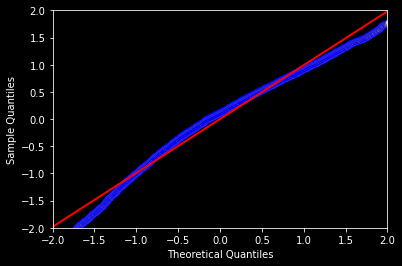

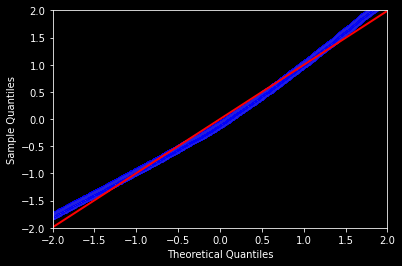

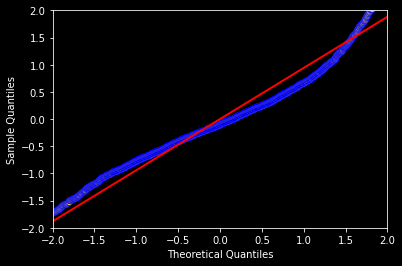

In [33]:
#using the model function we defined earlier to model and plot our qq plots for each income bracket 
for name, tier, income in price_tiers:
    print(name.upper())
    make_ols(tier, income)

## Refinement
First we're going to start filtering out outliers, helping normalize our data should improve our model 

In [34]:
# we're going to normalize price a bit by filtering out all of our homes more than or less than 2 
# standard deviations from our mean housing price 
for col in ['price']:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std()
    kc_data = kc_data.loc[kc_data[col_zscore] < 2]
    kc_data = kc_data.loc[kc_data[col_zscore] > (-2)]
    #we're also going to drop our z scored price, after exploring with it for a while 
    #we found the regular price much more helpful
    kc_data = kc_data.drop(col_zscore, axis = 1)

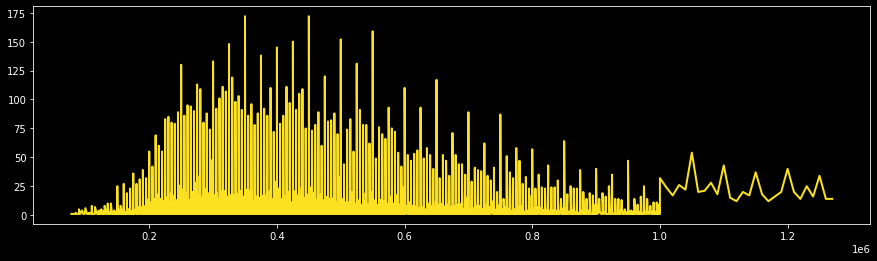

In [35]:
# taking a look at our prices to make sure they're normal enough for us to use 
plt.figure(figsize=(15,4))
plt.plot(kc_data['price'].value_counts().sort_index(), color='#FBE122')
# looks good!

In [103]:
# checking out our percentiles to see if there's anything weird we can see 
get_percentile(kc_data['price'])

0.01 percentile: 203844.0
0.02 percentile: 225000.0
0.03 percentile: 235000.0
0.04 percentile: 245000.0
0.05 percentile: 250000.0
0.06 percentile: 258970.0
0.07 percentile: 265000.0
0.08 percentile: 270000.0
0.09 percentile: 276000.0
0.1 percentile: 282000.0
0.11 percentile: 287500.0
0.12 percentile: 295752.32
0.13 percentile: 302000.0
0.14 percentile: 310000.0
0.15 percentile: 315320.0
0.16 percentile: 323000.0
0.17 percentile: 329950.0
0.18 percentile: 335000.0
0.19 percentile: 340000.0
0.2 percentile: 349950.0
0.21 percentile: 353762.0
0.22 percentile: 360000.0
0.23 percentile: 367783.92
0.24 percentile: 375000.0
0.25 percentile: 380000.0
0.26 percentile: 386500.0
0.27 percentile: 395000.0
0.28 percentile: 400000.0
0.29 percentile: 405000.0
0.3 percentile: 412000.0
0.31 percentile: 417939.99999999994
0.32 percentile: 422608.00000000006
0.33 percentile: 428000.0
0.34 percentile: 432500.0
0.35 percentile: 437399.9999999999
0.36 percentile: 441000.0
0.37 percentile: 448759.99999999977


In [33]:
#in bedrooms, we can clearly see a single outlier that is likely just a typo 
kc_data[kc_data['bedrooms'] == 33]
# wouldn't be realistic for a house with 33 bedrooms to only have a sqft_living of 1620 and only 1 3/4 bathrooms so we will adjust to 3 
kc_data[kc_data['bedrooms'] == 33] = kc_data[kc_data['bedrooms'] == 33].replace(33,3)

In [34]:
# to fix other outliers we will explore our data and find cutoffs that seem reasonable 
kc_data = kc_data.loc[kc_data['sqft_total'] <= 1.000000e+09] 
kc_data = kc_data.loc[kc_data['sqft_total'] >= 400000]
kc_data = kc_data.loc[kc_data['sqft_neighb'] <= 1.000000e+09]
kc_data = kc_data.loc[kc_data['sqft_habitable'] >= 400000]
kc_data = kc_data.loc[kc_data['sqft_habitable'] <= 1.000000e+07]
kc_data =  kc_data.loc[kc_data['bathrooms'] >= 1]
kc_data =  kc_data.loc[kc_data['bathrooms'] <= 5]
kc_data =  kc_data.loc[kc_data['bedrooms'] <= 7]

# The Final Models

In [35]:
# after quite a bit of modeling, these came down to our best price ranges per income bracket 
hightier = kc_data[(kc_data.price >= 640000) & (kc_data.price <= 900000)]
uppermidtier = kc_data[(kc_data.price >= 480000) & (kc_data.price <= 640000) ]
midtier = kc_data[(kc_data.price >= 348000) & (kc_data.price <= 480000) ]
lowtier = kc_data[(kc_data.price >= 210000) & (kc_data.price <= 348000) ]

In [36]:
# these are the features for each income bracket that have significant p-values & low correlation scores
# that help us produce the best fit model 
highincome = ['bathrooms', 'floors', 'sqft_neighb', 
              'sqft_habitable', 'thru2020',
              'zip006t011', 'zip107t115',
              'zip116t122', 'zip177t199', 
              'mi_2_scl', 'scls_in_mi', 'mi_2_rest',
              'mi_2_groc', 'groc_in_mi']

uppermedincome = ['bathrooms',  'lat', 'sqft_habitable',   
                  'C', 'Bmin', 'B', 
                  'zip014t024', 'zip027t031', 'zip032t039', 
                  'zip070t077', 'zip125t144', 'zip146t168', 
                  'thru2000', 'thru2020', 'thru60', 'thru80']

mediumincome = ['bathrooms',  'lat', 'long', 
                'sqft_habitable', 'view2',   
                'Cpl', 'Bmin', 'B', 'Bpl',   
                'zip006t011', 'zip014t024', 'zip032t039', 
                'zip055t065', 'zip070t077', 'zip092t106', 
                'zip177t199', 'rest_in_mi', 'groc_in_mi',
                'thru2000', 'thru2020', 'thru60', 'thru80']

lowincome = ['bathrooms', 'waterfront', 'lat', 'long',
             'sqft_total', 'sqft_habitable', 
             'view1', 'view2', 'view3', 
             'C', 'Cpl', 'Bmin', 'B',
             'zip040t053', 'zip055t065', 'zip092t106', 
             'zip107t115', 'zip146t168', 
             'groc_in_mi']

In [37]:
# since we added another price bracket we need to redefine our price tiers 
price_tiers = [('high', hightier, highincome),
               ('upmid', uppermidtier, uppermedincome),
               ('mid', midtier, mediumincome),
               ('low', lowtier, lowincome)]

LOW


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              5956.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        17:30:55   Log-Likelihood:                         -14113.
No. Observations:                1203   AIC:                                  2.826e+04
Df Residuals:                    1185   BIC:                                  2.835e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       6685.2849   1789.688      3.735      0.000    3173.975    1.02e+04
waterfront      5.107e-05    7.1e-06      7.192      0.000    3.71e-05     6.5e-05
lat             1.117e+05   8057.908     13.862      0.000    9.59e+04    1.28e+05
long            4.168e+04   3126.918     13.330      0.000    3.55e+04    4.78e+04
sqft_total         0.0002   5.22e-05      4.787      0.000       0.000       0.000
sqft_habitable     0.0148      0.002      5.936      0.000       0.010       0.020
view1           2.894e+04   9241.758      3.132      0.002    1.08e+04    4.71e+04
view2           1.158e+04   5318.252      2.177      0.030    1143.458     2.2e+04
view3           2.573e+04   1.02e+04      2.522      0.012    5712.425    4.57e+04
C               3.192e+04    1.4e+04      2.279      0.023    4435.039    5.94e+04
Cpl              4.32e+04   1.37e+04      3.152      0.002    1.63e+04    7.01e+04
Bmin            5.752e+04   1.39e+04      4.140      0.000    3.03e+04    8.48e+04
B               6.565e+04   1.79e+04      3.661      0.000    3.05e+04    1.01e+05
zip040t053     -1.064e+04   4126.293     -2.578      0.010   -1.87e+04   -2540.778
zip055t065      1.618e+04   2745.268      5.895      0.000    1.08e+04    2.16e+04
zip092t106      9966.5253   3857.924      2.583      0.010    2397.402    1.75e+04
zip107t115      2.381e+04   5711.167      4.169      0.000    1.26e+04     3.5e+04
zip146t168      7588.0355   2974.927      2.551      0.011    1751.323    1.34e+04
groc_in_mi      3099.8130    835.577      3.710      0.000    1460.438    4739.188
==============================================================================
Omnibus:                        8.928   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                7.871
Skew:                          -0.139   Prob(JB):                       0.0195
Kurtosis:                       2.718   Cond. No.                     1.34e+19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 5.01e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

MID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.036e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        17:30:55   Log-Likelihood:                         -18521.
No. Observations:                1561   AIC:                                  3.709e+04
Df Residuals:                    1539   BIC:                                  3.720e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       6011.6770   2014.842      2.984      0.003    2059.552    9963.802
lat             7.359e+04   7872.108      9.348      0.000    5.81e+04     8.9e+04
long            2.543e+04   3068.290      8.289      0.000    1.94e+04    3.15e+04
sqft_habitable     0.0078      0.002      4.263      0.000       0.004       0.011
view2           1.377e+04   4375.178      3.147      0.002    5188.000    2.24e+04
Cpl             8660.5119   3823.641      2.265      0.024    1160.414    1.62e+04
Bmin            2.319e+04   4260.868      5.443      0.000    1.48e+04    3.16e+04
B               3.573e+04   6977.245      5.121      0.000     2.2e+04    4.94e+04
Bpl             5.675e+04   1.15e+04      4.948      0.000    3.43e+04    7.92e+04
zip006t011       1.61e+04   4015.373      4.009      0.000    8222.417     2.4e+04
zip014t024     -1.868e+04   5439.259     -3.435      0.001   -2.94e+04   -8015.040
zip032t039      1.453e+04   3243.249      4.479      0.000    8166.447    2.09e+04
zip055t065     -1.605e+04   3452.999     -4.649      0.000   -2.28e+04   -9278.269
zip070t077      1.114e+04   4271.481      2.608      0.009    2761.815    1.95e+04
zip092t106     -1.389e+04   4029.110     -3.447      0.001   -2.18e+04   -5985.807
zip177t199     -1.144e+04   3638.708     -3.143      0.002   -1.86e+04   -4300.106
rest_in_mi       648.2073    132.261      4.901      0.000     388.777     907.637
groc_in_mi     -2286.3251    900.896     -2.538      0.011   -4053.439    -519.211
thru2000       -1.737e+04   4070.207     -4.268      0.000   -2.54e+04   -9388.915
thru2020       -9762.5072   4804.642     -2.032      0.042   -1.92e+04    -338.169
thru60         -9730.4651   3414.660     -2.850      0.004   -1.64e+04   -3032.587
thru80          -1.89e+04   3604.101     -5.244      0.000    -2.6e+04   -1.18e+04
==============================================================================
Omnibus:                       95.366   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.790
Skew:                          -0.087   Prob(JB):                     1.03e-08
Kurtosis:                       2.268   Cond. No.                     1.68e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.68e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

UPMID


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.719e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        17:30:55   Log-Likelihood:                         -20469.
No. Observations:                1692   AIC:                                  4.097e+04
Df Residuals:                    1676   BIC:                                  4.106e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       8953.9234   2220.935      4.032      0.000    4597.825    1.33e+04
lat             1.136e+04     97.483    116.536      0.000    1.12e+04    1.16e+04
sqft_habitable     0.0078      0.002      4.430      0.000       0.004       0.011
C              -2.515e+04   7950.739     -3.163      0.002   -4.07e+04   -9555.700
Bmin            1.546e+04   2505.203      6.173      0.000    1.06e+04    2.04e+04
B               2.438e+04   4711.434      5.174      0.000    1.51e+04    3.36e+04
zip014t024      -2.17e+04   8201.155     -2.646      0.008   -3.78e+04   -5618.161
zip027t031     -1.279e+04   4456.597     -2.871      0.004   -2.15e+04   -4052.078
zip032t039     -1.038e+04   4467.540     -2.324      0.020   -1.91e+04   -1620.032
zip070t077     -8563.0595   4286.680     -1.998      0.046    -1.7e+04    -155.250
zip125t144     -1.224e+04   3467.766     -3.531      0.000    -1.9e+04   -5442.646
zip146t168     -1.721e+04   5123.460     -3.358      0.001   -2.73e+04   -7156.203
thru2000       -2.787e+04   4386.117     -6.355      0.000   -3.65e+04   -1.93e+04
thru2020       -2.502e+04   5018.121     -4.986      0.000   -3.49e+04   -1.52e+04
thru60         -9157.4647   3416.426     -2.680      0.007   -1.59e+04   -2456.554
thru80         -2.526e+04   3500.447     -7.216      0.000   -3.21e+04   -1.84e+04
==============================================================================
Omnibus:                      218.189   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.615
Skew:                           0.073   Prob(JB):                     3.08e-13
Kurtosis:                       2.108   Cond. No.                     1.10e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.1e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

HIGH


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2721.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        17:30:55   Log-Likelihood:                         -18305.
No. Observations:                1379   AIC:                                  3.664e+04
Df Residuals:                    1365   BIC:                                  3.671e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       1.299e+05   6505.247     19.967      0.000    1.17e+05    1.43e+05
floors          1.156e+05   9680.582     11.937      0.000    9.66e+04    1.35e+05
sqft_neighb       -0.0002   8.71e-05     -2.861      0.004      -0.000   -7.83e-05
sqft_habitable     0.0261      0.005      5.149      0.000       0.016       0.036
thru2020       -1.524e+05   1.24e+04    -12.309      0.000   -1.77e+05   -1.28e+05
zip006t011      5.735e+04    1.4e+04      4.100      0.000    2.99e+04    8.48e+04
zip107t115      3.518e+04   1.31e+04      2.683      0.007    9459.682    6.09e+04
zip116t122      5.478e+04   1.17e+04      4.677      0.000    3.18e+04    7.78e+04
zip177t199      1.303e+05   1.38e+04      9.428      0.000    1.03e+05    1.57e+05
mi_2_scl        1.031e+05   1.39e+04      7.423      0.000    7.58e+04     1.3e+05
scls_in_mi      2.103e+04   1624.014     12.946      0.000    1.78e+04    2.42e+04
mi_2_rest       8.013e+04   1.26e+04      6.381      0.000    5.55e+04    1.05e+05
mi_2_groc       6538.8325   3115.740      2.099      0.036     426.675    1.27e+04
groc_in_mi      9388.9098   3683.686      2.549      0.011    2162.610    1.66e+04
==============================================================================
Omnibus:                       94.518   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.829
Skew:                          -0.535   Prob(JB):                     1.31e-32
Kurtosis:                       4.187   Cond. No.                     2.56e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

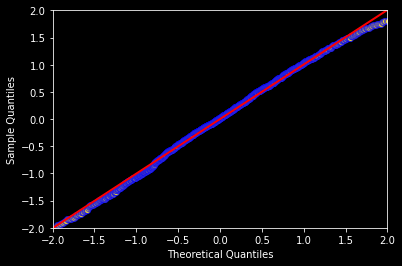

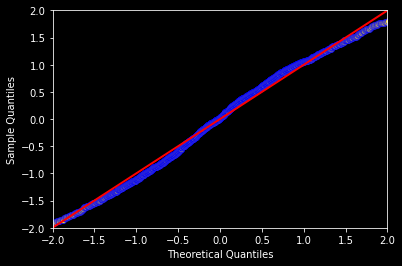

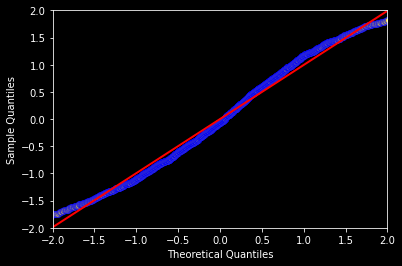

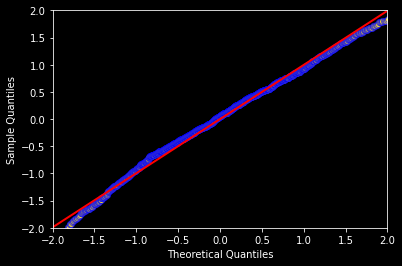

In [38]:
# getting our final model, printing them in income order followed by their qq-plots 
for name, tier, income in price_tiers:
    print(name.upper())
    make_ols(tier, income)

# Train Split Test - High Income

In [46]:
#first step is to seperate out the data we're going to use for this model
high_data = hightier[['price', 'bathrooms', 'floors', 'sqft_neighb', 
                      'sqft_habitable', 'thru2020',
                      'zip006t011', 'zip107t115',
                      'zip116t122', 'zip177t199', 
                      'mi_2_scl', 'scls_in_mi', 'mi_2_rest',
                      'mi_2_groc', 'groc_in_mi']].copy()
# splitting it into 25/75 training/testing data to make sure our model is consistent 
training_data, testing_data = train_test_split(high_data, test_size=0.25, random_state=44)

In [47]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              2721.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        17:32:15   Log-Likelihood:                         -18305.
No. Observations:                1379   AIC:                                  3.664e+04
Df Residuals:                    1365   BIC:                                  3.671e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       1.299e+05   6505.247     19.967      0.000    1.17e+05    1.43e+05
floors          1.156e+05   9680.582     11.937      0.000    9.66e+04    1.35e+05
sqft_neighb       -0.0002   8.71e-05     -2.861      0.004      -0.000   -7.83e-05
sqft_habitable     0.0261      0.005      5.149      0.000       0.016       0.036
thru2020       -1.524e+05   1.24e+04    -12.309      0.000   -1.77e+05   -1.28e+05
zip006t011      5.735e+04    1.4e+04      4.100      0.000    2.99e+04    8.48e+04
zip107t115      3.518e+04   1.31e+04      2.683      0.007    9459.682    6.09e+04
zip116t122      5.478e+04   1.17e+04      4.677      0.000    3.18e+04    7.78e+04
zip177t199      1.303e+05   1.38e+04      9.428      0.000    1.03e+05    1.57e+05
mi_2_scl        1.031e+05   1.39e+04      7.423      0.000    7.58e+04     1.3e+05
scls_in_mi      2.103e+04   1624.014     12.946      0.000    1.78e+04    2.42e+04
mi_2_rest       8.013e+04   1.26e+04      6.381      0.000    5.55e+04    1.05e+05
mi_2_groc       6538.8325   3115.740      2.099      0.036     426.675    1.27e+04
groc_in_mi      9388.9098   3683.686      2.549      0.011    2162.610    1.66e+04
==============================================================================
Omnibus:                       94.518   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.829
Skew:                          -0.535   Prob(JB):                     1.31e-32
Kurtosis:                       4.187   Cond. No.                     2.56e+08
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

thru2020         -152439.241198
sqft_neighb           -0.000249
sqft_habitable         0.026095
mi_2_groc           6538.832469
groc_in_mi          9388.909791
scls_in_mi         21025.150029
zip107t115         35179.008971
zip116t122         54783.569269
zip006t011         57346.841388
mi_2_rest          80134.655626
mi_2_scl          103064.882671
floors            115554.792618
bathrooms         129887.385510
zip177t199        130306.445355
dtype: float64

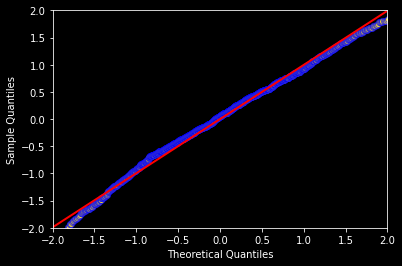

In [48]:
#assign model a name so we can call on it to plot later on 
high_model = make_ols(hightier, predictive_cols)

### Interpreting High Income 

In [ ]:
#print and take a look at our coefficients 
high_model.params.sort_values()

Training MSE: 19786689216.778683 
Testing MSE: 19970927110.655766
Training Error: $ 140665.16703426858 
Testing Error: 141318.53066974538


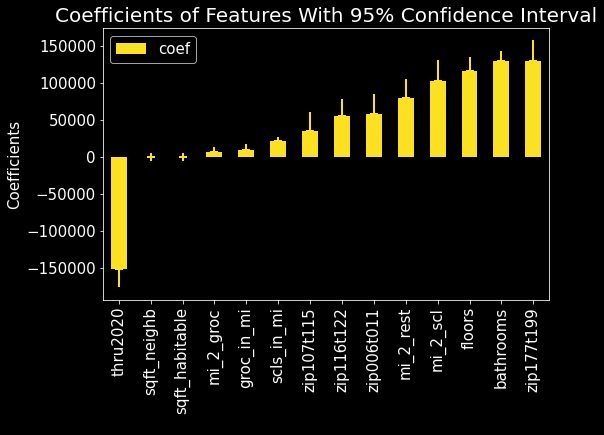

In [49]:
# assign your predictions 
y_pred_train = high_model.predict(training_data[predictive_cols])
y_pred_test = high_model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)

In [ ]:
#calculating MSE and converting it to $ 
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
print('Training Error: $', sqrt(train_mse), '\nTesting Error:', sqrt(test_mse))

In [ ]:
#plotting our coefficients 
plotcoef(high_model)

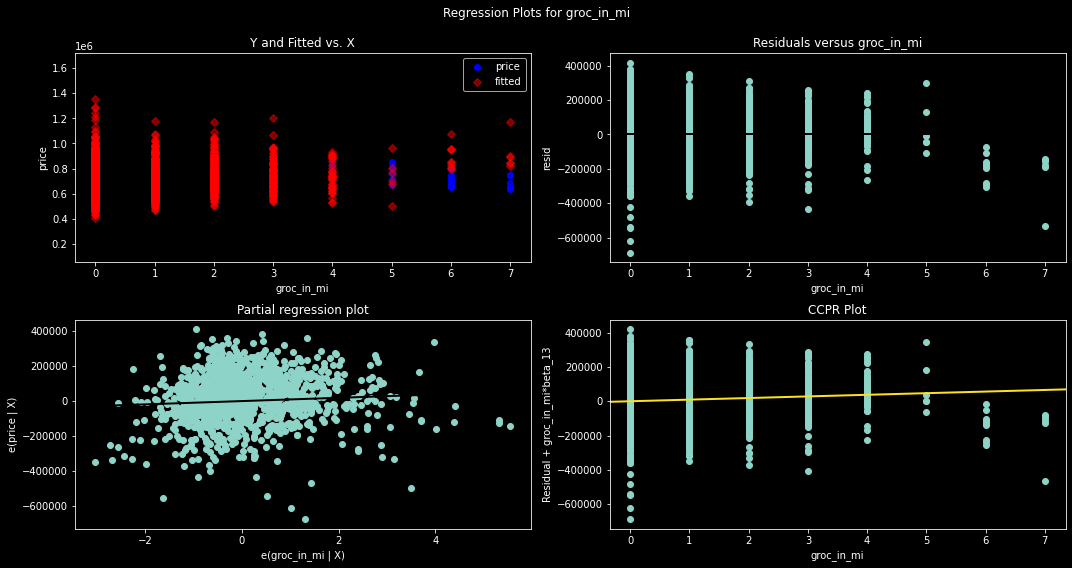

In [50]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(high_model, "groc_in_mi", fig=fig)
plt.show()

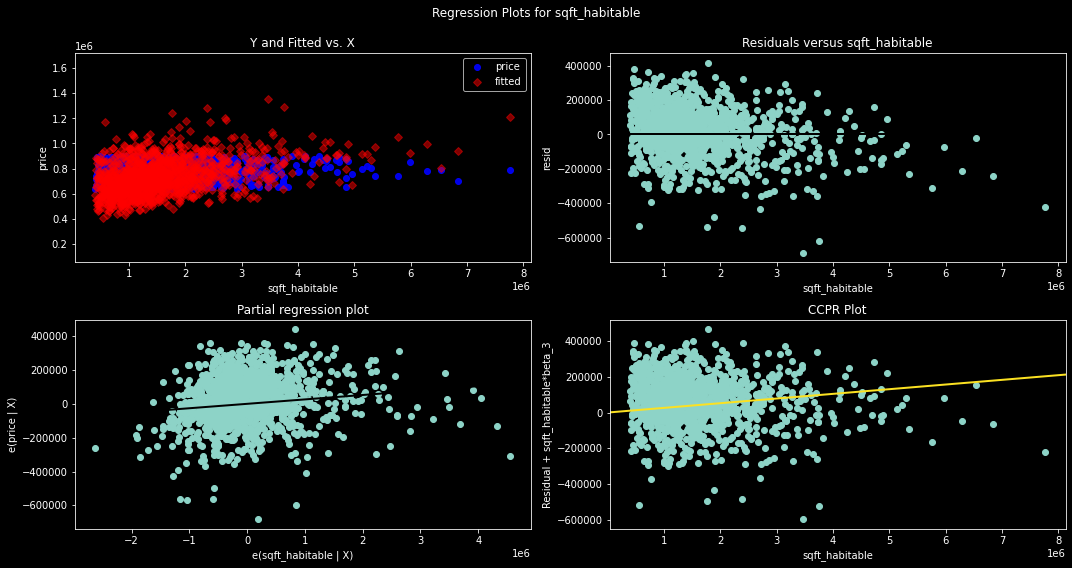

In [51]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(high_model, "sqft_habitable", fig=fig)
plt.show()

# Testing - Upper-Medium Income

In [52]:
#first step is to seperate out the data we're going to use for this model
upper_med_data = uppermidtier[['bathrooms',  'lat', 'sqft_habitable',   
                               'C', 'Bmin', 'B', 'price',
                               'zip014t024', 'zip027t031', 'zip032t039', 
                               'zip070t077', 'zip125t144', 'zip146t168', 
                               'thru2000', 'thru2020', 'thru60', 'thru80']].copy()
# splitting it into 25/75 training/testing data to make sure our model is consistent 
training_data, testing_data = train_test_split(upper_med_data,test_size=0.30, random_state=55)

In [53]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          1.195e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        17:33:08   Log-Likelihood:                         -14327.
No. Observations:                1184   AIC:                                  2.869e+04
Df Residuals:                    1168   BIC:                                  2.877e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       7154.1438   2659.550      2.690      0.007    1936.115    1.24e+04
lat             1.143e+04    116.568     98.081      0.000    1.12e+04    1.17e+04
sqft_habitable     0.0068      0.002      3.281      0.001       0.003       0.011
C              -1.127e+04   1.06e+04     -1.065      0.287    -3.2e+04    9487.835
Bmin            1.729e+04   3037.073      5.692      0.000    1.13e+04    2.32e+04
B                3.08e+04   5592.671      5.507      0.000    1.98e+04    4.18e+04
zip014t024     -2.961e+04   1.02e+04     -2.913      0.004   -4.96e+04   -9664.640
zip027t031     -1.144e+04   5390.363     -2.123      0.034    -2.2e+04    -868.932
zip032t039     -1.261e+04   5291.267     -2.384      0.017    -2.3e+04   -2233.227
zip070t077      -1.12e+04   5402.620     -2.072      0.038   -2.18e+04    -596.024
zip125t144     -1.312e+04   4072.725     -3.221      0.001   -2.11e+04   -5126.175
zip146t168     -1.537e+04   6400.234     -2.401      0.017   -2.79e+04   -2808.884
thru2000        -2.63e+04   5364.627     -4.903      0.000   -3.68e+04   -1.58e+04
thru2020       -2.474e+04   6239.325     -3.965      0.000    -3.7e+04   -1.25e+04
thru60         -6322.2154   4068.149     -1.554      0.120   -1.43e+04    1659.481
thru80           -2.4e+04   4176.344     -5.747      0.000   -3.22e+04   -1.58e+04
==============================================================================
Omnibus:                      139.685   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.547
Skew:                           0.056   Prob(JB):                     4.26e-09
Kurtosis:                       2.123   Cond. No.                     1.18e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.18e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

zip014t024       -29608.004350
thru2000         -26304.921995
thru2020         -24739.614665
thru80           -24001.176646
zip146t168       -15366.125102
zip125t144       -13116.848770
zip032t039       -12614.678051
zip027t031       -11444.809354
C                -11274.380188
zip070t077       -11195.948182
thru60            -6322.215394
sqft_habitable        0.006819
bathrooms          7154.143802
lat               11433.153142
Bmin              17285.913155
B                 30798.130657
dtype: float64

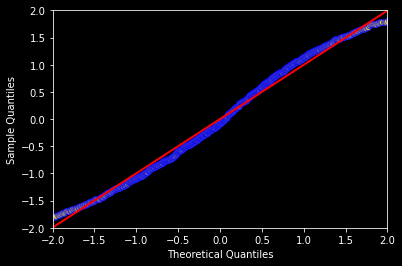

In [54]:
#assign model a name so we can call on it to plot later on 
uppmid_model = make_ols(training_data, predictive_cols)

### Interpreting Upper Medium Income 

In [ ]:
#print and take a look at our coefficients 
uppmid_model.params.sort_values()

Training MSE: 1896478217.5414462 
Testing MSE: 1896787318.4337904
Training Error: $ 43548.573082725066 
Testing Error: 43552.12185914471


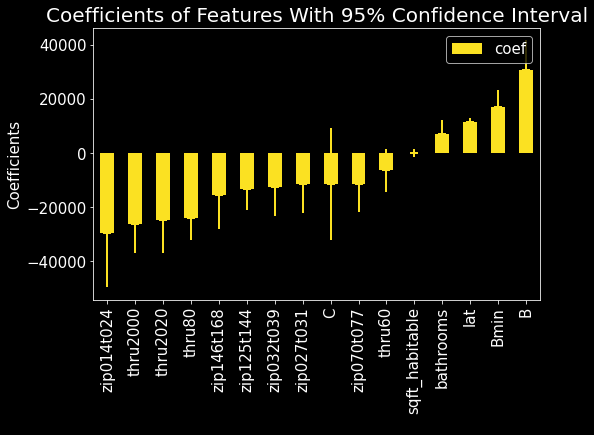

In [55]:
# assign your predictions 
y_pred_train = uppmid_model.predict(training_data[predictive_cols])
y_pred_test = uppmid_model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)

In [ ]:
#calculating MSE and converting it to $ 
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
print('Training Error: $', sqrt(train_mse), '\nTesting Error:', sqrt(test_mse))

In [ ]:
#plotting our coefficients 
plotcoef(uppmid_model)

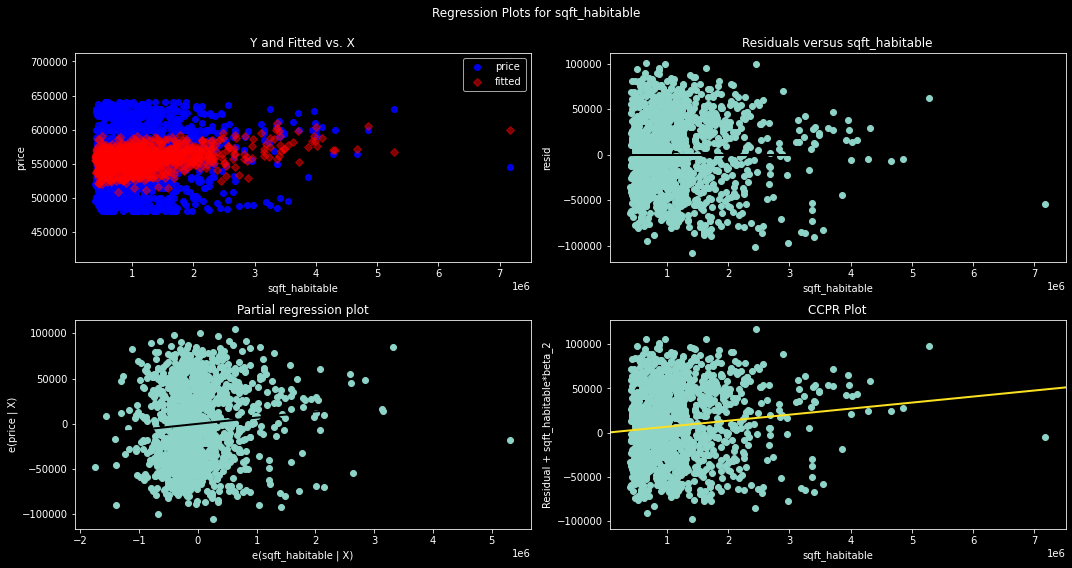

In [56]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(uppmid_model, "sqft_habitable", fig=fig)
plt.show()

# Testing - Medium Income

In [80]:
#first step is to seperate out the data we're going to use for this model
mid_data = midtier[['bathrooms',  'lat', 'long', 
                    'sqft_habitable', 'view2', 'price', 
                    'Cpl', 'Bmin', 'B', 'Bpl',   
                    'zip006t011', 'zip014t024', 'zip032t039', 
                    'zip055t065', 'zip070t077', 'zip092t106', 
                    'zip177t199', 'rest_in_mi', 'groc_in_mi',
                    'thru2000', 'thru2020', 'thru60', 'thru80']].copy()
# splitting it into 25/75 training/testing data to make sure our model is consistent 
training_data, testing_data = train_test_split(mid_data, test_size=0.30, random_state=70)

In [81]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          1.036e+04
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        17:37:25   Log-Likelihood:                         -18521.
No. Observations:                1561   AIC:                                  3.709e+04
Df Residuals:                    1539   BIC:                                  3.720e+04
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       6011.6770   2014.842      2.984      0.003    2059.552    9963.802
lat             7.359e+04   7872.108      9.348      0.000    5.81e+04     8.9e+04
long            2.543e+04   3068.290      8.289      0.000    1.94e+04    3.15e+04
sqft_habitable     0.0078      0.002      4.263      0.000       0.004       0.011
view2           1.377e+04   4375.178      3.147      0.002    5188.000    2.24e+04
Cpl             8660.5119   3823.641      2.265      0.024    1160.414    1.62e+04
Bmin            2.319e+04   4260.868      5.443      0.000    1.48e+04    3.16e+04
B               3.573e+04   6977.245      5.121      0.000     2.2e+04    4.94e+04
Bpl             5.675e+04   1.15e+04      4.948      0.000    3.43e+04    7.92e+04
zip006t011       1.61e+04   4015.373      4.009      0.000    8222.417     2.4e+04
zip014t024     -1.868e+04   5439.259     -3.435      0.001   -2.94e+04   -8015.040
zip032t039      1.453e+04   3243.249      4.479      0.000    8166.447    2.09e+04
zip055t065     -1.605e+04   3452.999     -4.649      0.000   -2.28e+04   -9278.269
zip070t077      1.114e+04   4271.481      2.608      0.009    2761.815    1.95e+04
zip092t106     -1.389e+04   4029.110     -3.447      0.001   -2.18e+04   -5985.807
zip177t199     -1.144e+04   3638.708     -3.143      0.002   -1.86e+04   -4300.106
rest_in_mi       648.2073    132.261      4.901      0.000     388.777     907.637
groc_in_mi     -2286.3251    900.896     -2.538      0.011   -4053.439    -519.211
thru2000       -1.737e+04   4070.207     -4.268      0.000   -2.54e+04   -9388.915
thru2020       -9762.5072   4804.642     -2.032      0.042   -1.92e+04    -338.169
thru60         -9730.4651   3414.660     -2.850      0.004   -1.64e+04   -3032.587
thru80          -1.89e+04   3604.101     -5.244      0.000    -2.6e+04   -1.18e+04
==============================================================================
Omnibus:                       95.366   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.790
Skew:                          -0.087   Prob(JB):                     1.03e-08
Kurtosis:                       2.268   Cond. No.                     1.68e+07
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.68e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

thru80           -18899.174319
zip014t024       -18684.182864
thru2000         -17372.651997
zip055t065       -16051.348733
zip092t106       -13888.933520
zip177t199       -11437.456606
thru2020          -9762.507182
thru60            -9730.465105
groc_in_mi        -2286.325066
sqft_habitable        0.007762
rest_in_mi          648.207308
bathrooms          6011.676982
Cpl                8660.511945
zip070t077        11140.353426
view2             13769.940499
zip032t039        14528.102034
zip006t011        16098.596502
Bmin              23193.661364
long              25432.200978
B                 35731.160303
Bpl               56745.550579
lat               73590.590769
dtype: float64

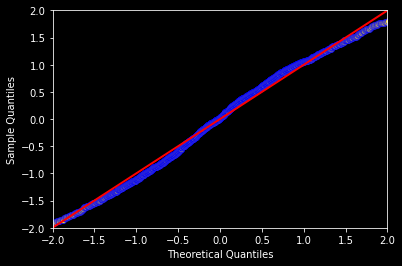

In [82]:
#assign model a name so we can call on it to plot later on 
mid_model = make_ols(mid_data, predictive_cols)

### Interpreting Medium Income 

In [ ]:
#print and take a look at our coefficients 
mid_model.params.sort_values()

Training MSE: 1174108957.3746374 
Testing MSE: 1203709924.776451
Training Error: $ 34265.27334451948 
Testing Error: 34694.52297952014


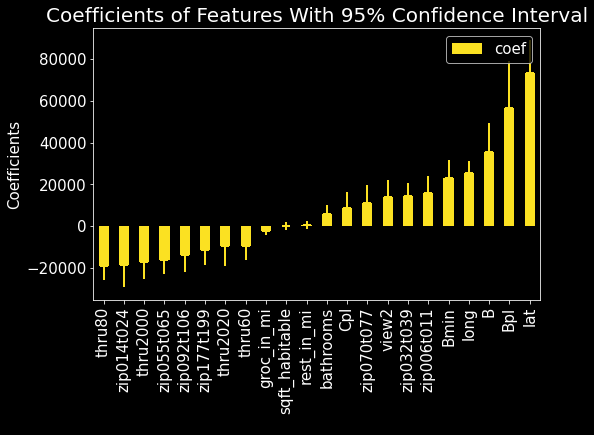

In [83]:
# assign your preditions 
y_pred_train = mid_model.predict(training_data[predictive_cols])
y_pred_test = mid_model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)

In [ ]:
#calculating MSE and converting it to $ 
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
print('Training Error: $', sqrt(train_mse), '\nTesting Error:', sqrt(test_mse))

In [ ]:
#plotting our coefficients 
plotcoef(mid_model)

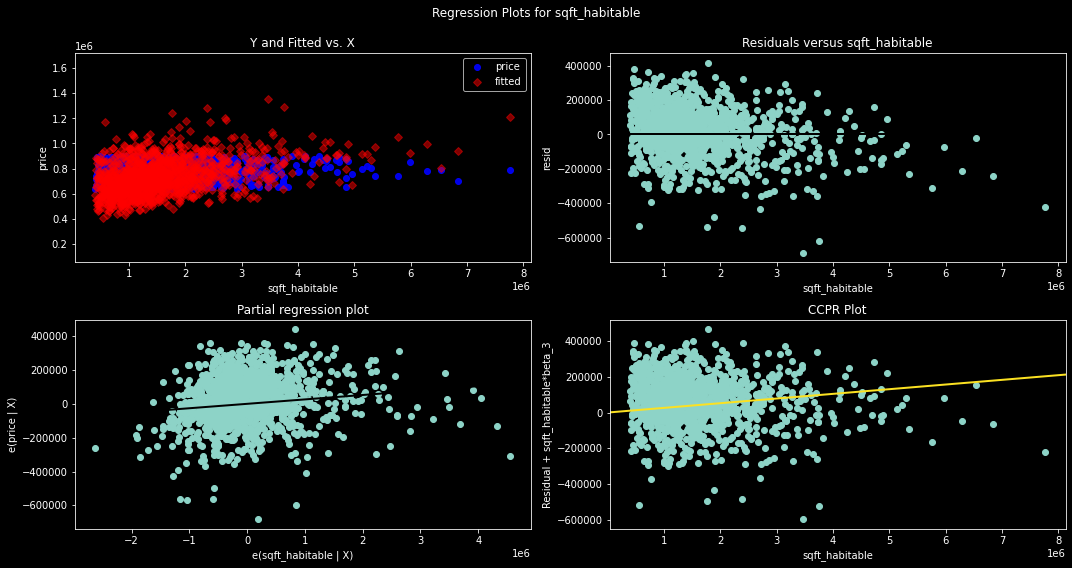

In [84]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(high_model, "sqft_habitable", fig=fig)
plt.show()

# Testing - Low Income 

In [85]:
#first step is to seperate out the data we're going to use for this model
low_data = lowtier[['bathrooms', 'waterfront', 'lat', 'long',
                    'sqft_total', 'sqft_habitable', 
                    'view1', 'view2', 'view3', 
                    'C', 'Cpl', 'Bmin', 'B', 'price',
                    'zip040t053', 'zip055t065', 'zip092t106', 
                    'zip107t115', 'zip146t168', 
                    'groc_in_mi']].copy()

training_data, testing_data = train_test_split(low_data, test_size=0.25, random_state=66)

In [86]:
#split columns
target = 'price'
predictive_cols = training_data.drop('price', 1).columns

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.989
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              5956.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):                        0.00
Time:                        17:37:37   Log-Likelihood:                         -14113.
No. Observations:                1203   AIC:                                  2.826e+04
Df Residuals:                    1185   BIC:                                  2.835e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
bathrooms       6685.2849   1789.688      3.735      0.000    3173.975    1.02e+04
waterfront      5.107e-05    7.1e-06      7.192      0.000    3.71e-05     6.5e-05
lat             1.117e+05   8057.908     13.862      0.000    9.59e+04    1.28e+05
long            4.168e+04   3126.918     13.330      0.000    3.55e+04    4.78e+04
sqft_total         0.0002   5.22e-05      4.787      0.000       0.000       0.000
sqft_habitable     0.0148      0.002      5.936      0.000       0.010       0.020
view1           2.894e+04   9241.758      3.132      0.002    1.08e+04    4.71e+04
view2           1.158e+04   5318.252      2.177      0.030    1143.458     2.2e+04
view3           2.573e+04   1.02e+04      2.522      0.012    5712.425    4.57e+04
C               3.192e+04    1.4e+04      2.279      0.023    4435.039    5.94e+04
Cpl              4.32e+04   1.37e+04      3.152      0.002    1.63e+04    7.01e+04
Bmin            5.752e+04   1.39e+04      4.140      0.000    3.03e+04    8.48e+04
B               6.565e+04   1.79e+04      3.661      0.000    3.05e+04    1.01e+05
zip040t053     -1.064e+04   4126.293     -2.578      0.010   -1.87e+04   -2540.778
zip055t065      1.618e+04   2745.268      5.895      0.000    1.08e+04    2.16e+04
zip092t106      9966.5253   3857.924      2.583      0.010    2397.402    1.75e+04
zip107t115      2.381e+04   5711.167      4.169      0.000    1.26e+04     3.5e+04
zip146t168      7588.0355   2974.927      2.551      0.011    1751.323    1.34e+04
groc_in_mi      3099.8130    835.577      3.710      0.000    1460.438    4739.188
==============================================================================
Omnibus:                        8.928   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                7.871
Skew:                          -0.139   Prob(JB):                       0.0195
Kurtosis:                       2.718   Cond. No.                     1.34e+19
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 5.01e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

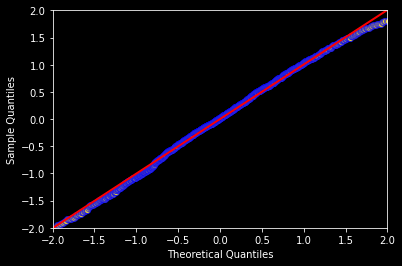

In [87]:
#assign model a name so we can call on it to plot later on 
low_model = make_ols(low_data, predictive_cols)

### Interpreting Low Income Model  

In [65]:
#print and take a look at our coefficients 
low_model.params.sort_values()

zip040t053        -10636.432730
waterfront             0.000051
sqft_total             0.000250
sqft_habitable         0.014809
groc_in_mi          3099.812983
bathrooms           6685.284904
zip146t168          7588.035549
zip092t106          9966.525265
view2              11577.698059
zip055t065         16184.563036
zip107t115         23807.963751
view3              25729.309161
view1              28942.727776
C                  31922.868796
long               41681.468302
Cpl                43201.341729
Bmin               57517.470809
B                  65654.540799
lat               111701.902308
dtype: float64

In [66]:
# assign your predictions 
y_pred_train = low_model.predict(training_data[predictive_cols])
y_pred_test = low_model.predict(testing_data[predictive_cols])
# then get the scores:
train_mse = mean_squared_error(training_data[target], y_pred_train)
test_mse = mean_squared_error(testing_data[target], y_pred_test)

Training MSE: 912877759.7470982 
Testing MSE: 890508475.1377867
Training Error: $ 30213.87 
Testing Error: $ 29841.39


In [ ]:
#calculating MSE and converting it to $ 
print('Training MSE:', train_mse, '\nTesting MSE:', test_mse)
print('Training Error: $', round(sqrt(train_mse), 2), '\nTesting Error: $', round(sqrt(test_mse), 2))

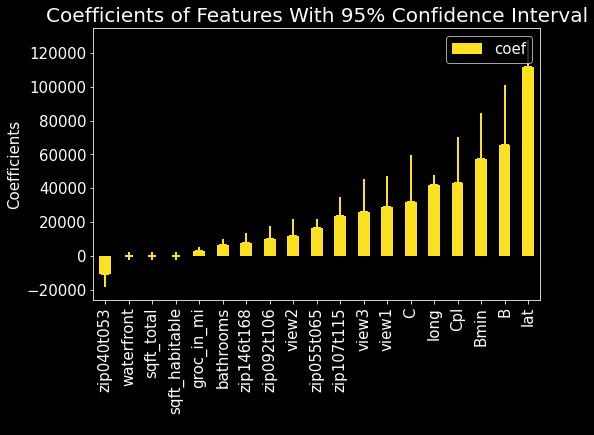

In [67]:
#plotting our coefficients 
plotcoef(low_model)

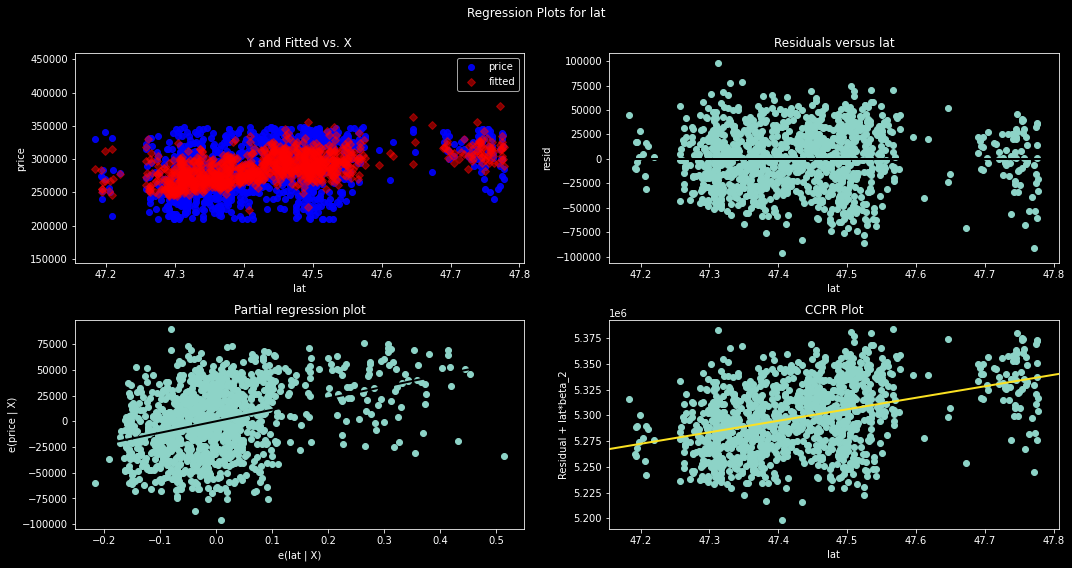

In [69]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(low_model, "lat", fig=fig)
plt.show()
#as you can see here, the farther west, towards the cities, you go, the more expensive homes become. 
#please note we are not missing data in those gaps, those represent bodies of water where few people live on small islands or in house boats 

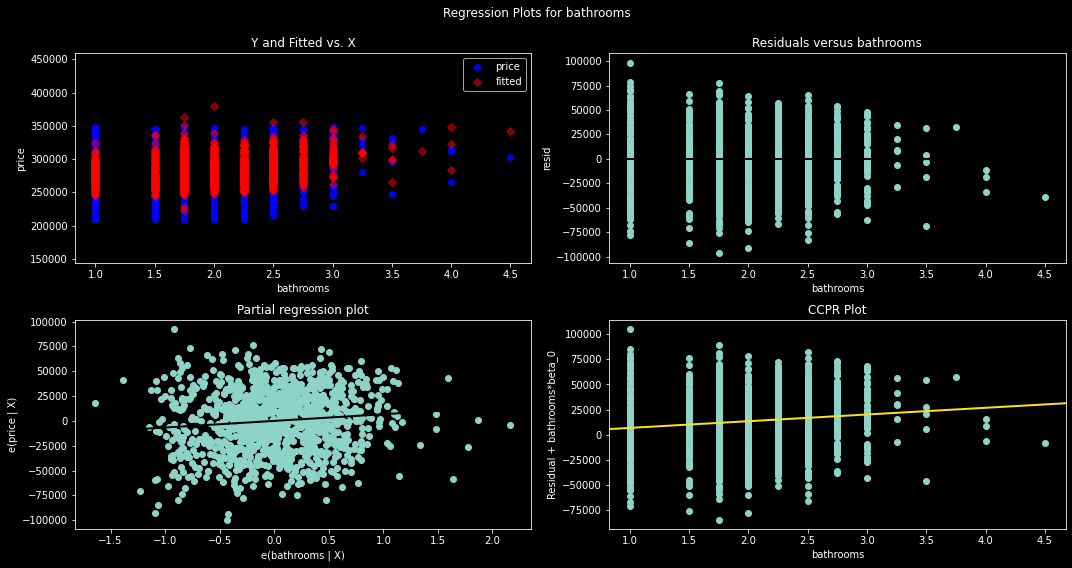

In [70]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(low_model, "bathrooms", fig=fig)
plt.show()
# 6,000$ doesn't look like much compared to prices in the 450,000, but, an increase from 1 to 4 could add over 20k and possibly bump you up to a higher 
# grade, making your home worth even more. 

AttributeError: 'float' object has no attribute 'shape'

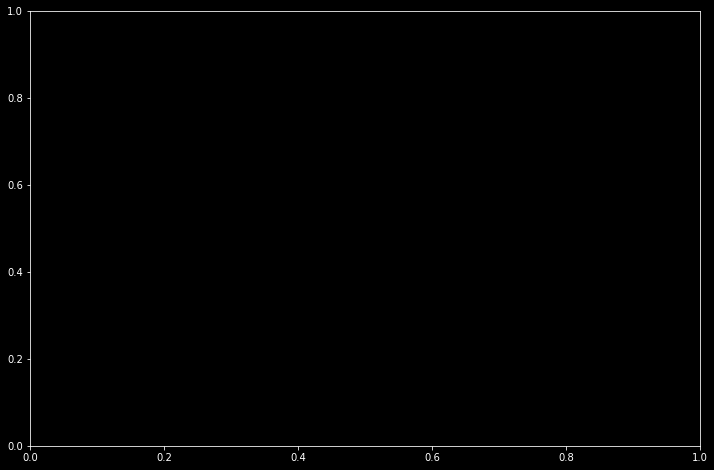

In [74]:
fig, ax = plt.subplots(figsize=(12,8))

sns.regplot(x='bathrooms', y='price', data=high_data, ci=95, marker='o', units=.25, color='green', scatter_kws={'s': 95})
ax.set(title='Bathooms & Price', 
       xlabel='Bathrooms', ylabel='Price', alpha =.75)

fig.tight_layout()

# Conclusions & Recommendations

# Observations
- Different incomes have different priorities when it comes to buying or selling a home. In short, Low income tends to put more priority on pragmatic space, While Middle Income homes tend to put more on location and grade, a trend that will increase with importance as you go up income brackets. Here are our best reccomendations. 

# Reccomendations 

### *Upper Class*
<p>
Buyer - If you want to live in Bill Gates neighborhood, near the waterfront, Downtown, or in one of Seattles Art Districts, you'll want to look for home built recently, as homes built after 2000 cost an average of 152,439.24 less. 
    
Seller - Add a loft, it's the most affordable and hip way to increase the number of stories you have and add an average of 115,554.79, while you're at it, we'd reccomend adding another bathroom as well, so long as you don't pass a 1:1 ratio with bedrooms. 
</p>

### *Upper Middle Class* 
<p>
Buyer - Move into a newer, more bland home. Homes built after 1960 cost around 25,000 less than more antique homes, but if they have a slightly above average design, they'll still cost a bit more. However, if you aim for a completely average home without any frills, you're likely to save around an additional 11,274.38, letting you buy an Upper Middle Class home for ~35k less overall. 
    
Seller - Make your homes look nicer by doing things like: adding a nice walkway, garden, some trim or fix up your roof; bringing your grade up to at least a B will increase your house worth by 30,798.13.
</p>

### *Middle Class* 
<p>

*Buyer* - Tech & buisness heavy neighborhoods like Downtown Seattle/Bellevue, and some of the surrounding areas, dont have very many grocery stores despite being very expensive, living just outside of this range will be cheaper by around a minimum of 11,437.45 and give you more access to grocery stores, while keeping you close enough for a short commute and generally being able to walk everywhere.
    
*Seller* - Add a balcony, bathroom, and other finishing touches to your home. Giving your home a view of something, and some extra features to increase your grade to a B+ will increase the value by over 56,745.55
</p>

### *Lower Class*  
<p>

*Buyer* - To save the most money & have easy access to grocery stores, it's best to live in more rural areas. Moving a few miles farther North or South of downtown Seattle/Bellevue, will save you 10-23k on average, and you can stay away from the city noise/dust while still being in a good distance for adequate public transit or to driving. 
    
*Seller* - In real estate many experts believe the best ratio is a minimum of 2 bathrooms for every 3 bedrooms, and that fitting your property to that ratio will likely increase your value significantly. Our numbers agree with this conclusion, so we reccomend you add a bathroom or two, so long as you don't exceed a 1:1 ratio for bedrooms and bathrooms, each bathroom will add around 6,685.28. 
</p>